In [9]:
import numpy as np
from bson import json_util
import helix as hx
from helix import units
import numpy as np
import strax as sx                    
from matplotlib import pyplot as plt
from glob import glob 
import os
import shutil

raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
run = 'run10' 
duration = 10  # seconds
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel 

In [2]:
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
hx.generate_toy_data(run, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]

    trace_idx: 0, start_idx: 0, ich: 0
    trace_idx: 1, start_idx: 135248, ich: 0
    trace_idx: 2, start_idx: 270496, ich: 0
    trace_idx: 3, start_idx: 405744, ich: 0
    trace_idx: 4, start_idx: 540992, ich: 0
    trace_idx: 5, start_idx: 676240, ich: 0
    trace_idx: 6, start_idx: 811488, ich: 0
    trace_idx: 7, start_idx: 946736, ich: 0
    trace_idx: 8, start_idx: 1081984, ich: 0
    trace_idx: 9, start_idx: 1217232, ich: 0
    trace_idx: 0, start_idx: 0, ich: 49
    trace_idx: 1, start_idx: 135248, ich: 49
    trace_idx: 2, start_idx: 270496, ich: 49
    trace_idx: 3, start_idx: 405744, ich: 49
    trace_idx: 4, start_idx: 540992, ich: 49
    trace_idx: 5, start_idx: 676240, ich: 49
    trace_idx: 6, start_idx: 811488, ich: 49
    trace_idx: 7, start_idx: 946736, ich: 49
    trace_idx: 8, start_idx: 1081984, ich: 49
    trace_idx: 9, start_idx: 1217232, ich: 49


In [10]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin
context.set_config(config)

In [11]:
run = 'run10' 
records = context.get_array(run, 'raw_records')
uv_triggers = context.get_array(run, 'uv_triggers')
qp_triggers = context.get_array(run, 'qp_triggers')
events = context.get_array(run, 'events')
fit_results = context.get_array(run, 'fit_results')  

raw_data = events['channel_data']

Loading raw_records: |              | 0.00 % [00:00<?], #1 (0.06 s). 2101.0 MB/s
Loading uv_triggers: |               | 0.00 % [00:00<?], #1 (0.00 s). 401.6 kB/s
Loading qp_triggers: |               | 0.00 % [00:00<?], #1 (0.00 s). 531.3 kB/s
Loading events: |                   | 0.00 % [00:00<?], #1 (0.03 s). 4330.9 MB/s
Loading fit_results: |                 | 0.00 % [00:00<?], #1 (0.00 s). 9.1 MB/s


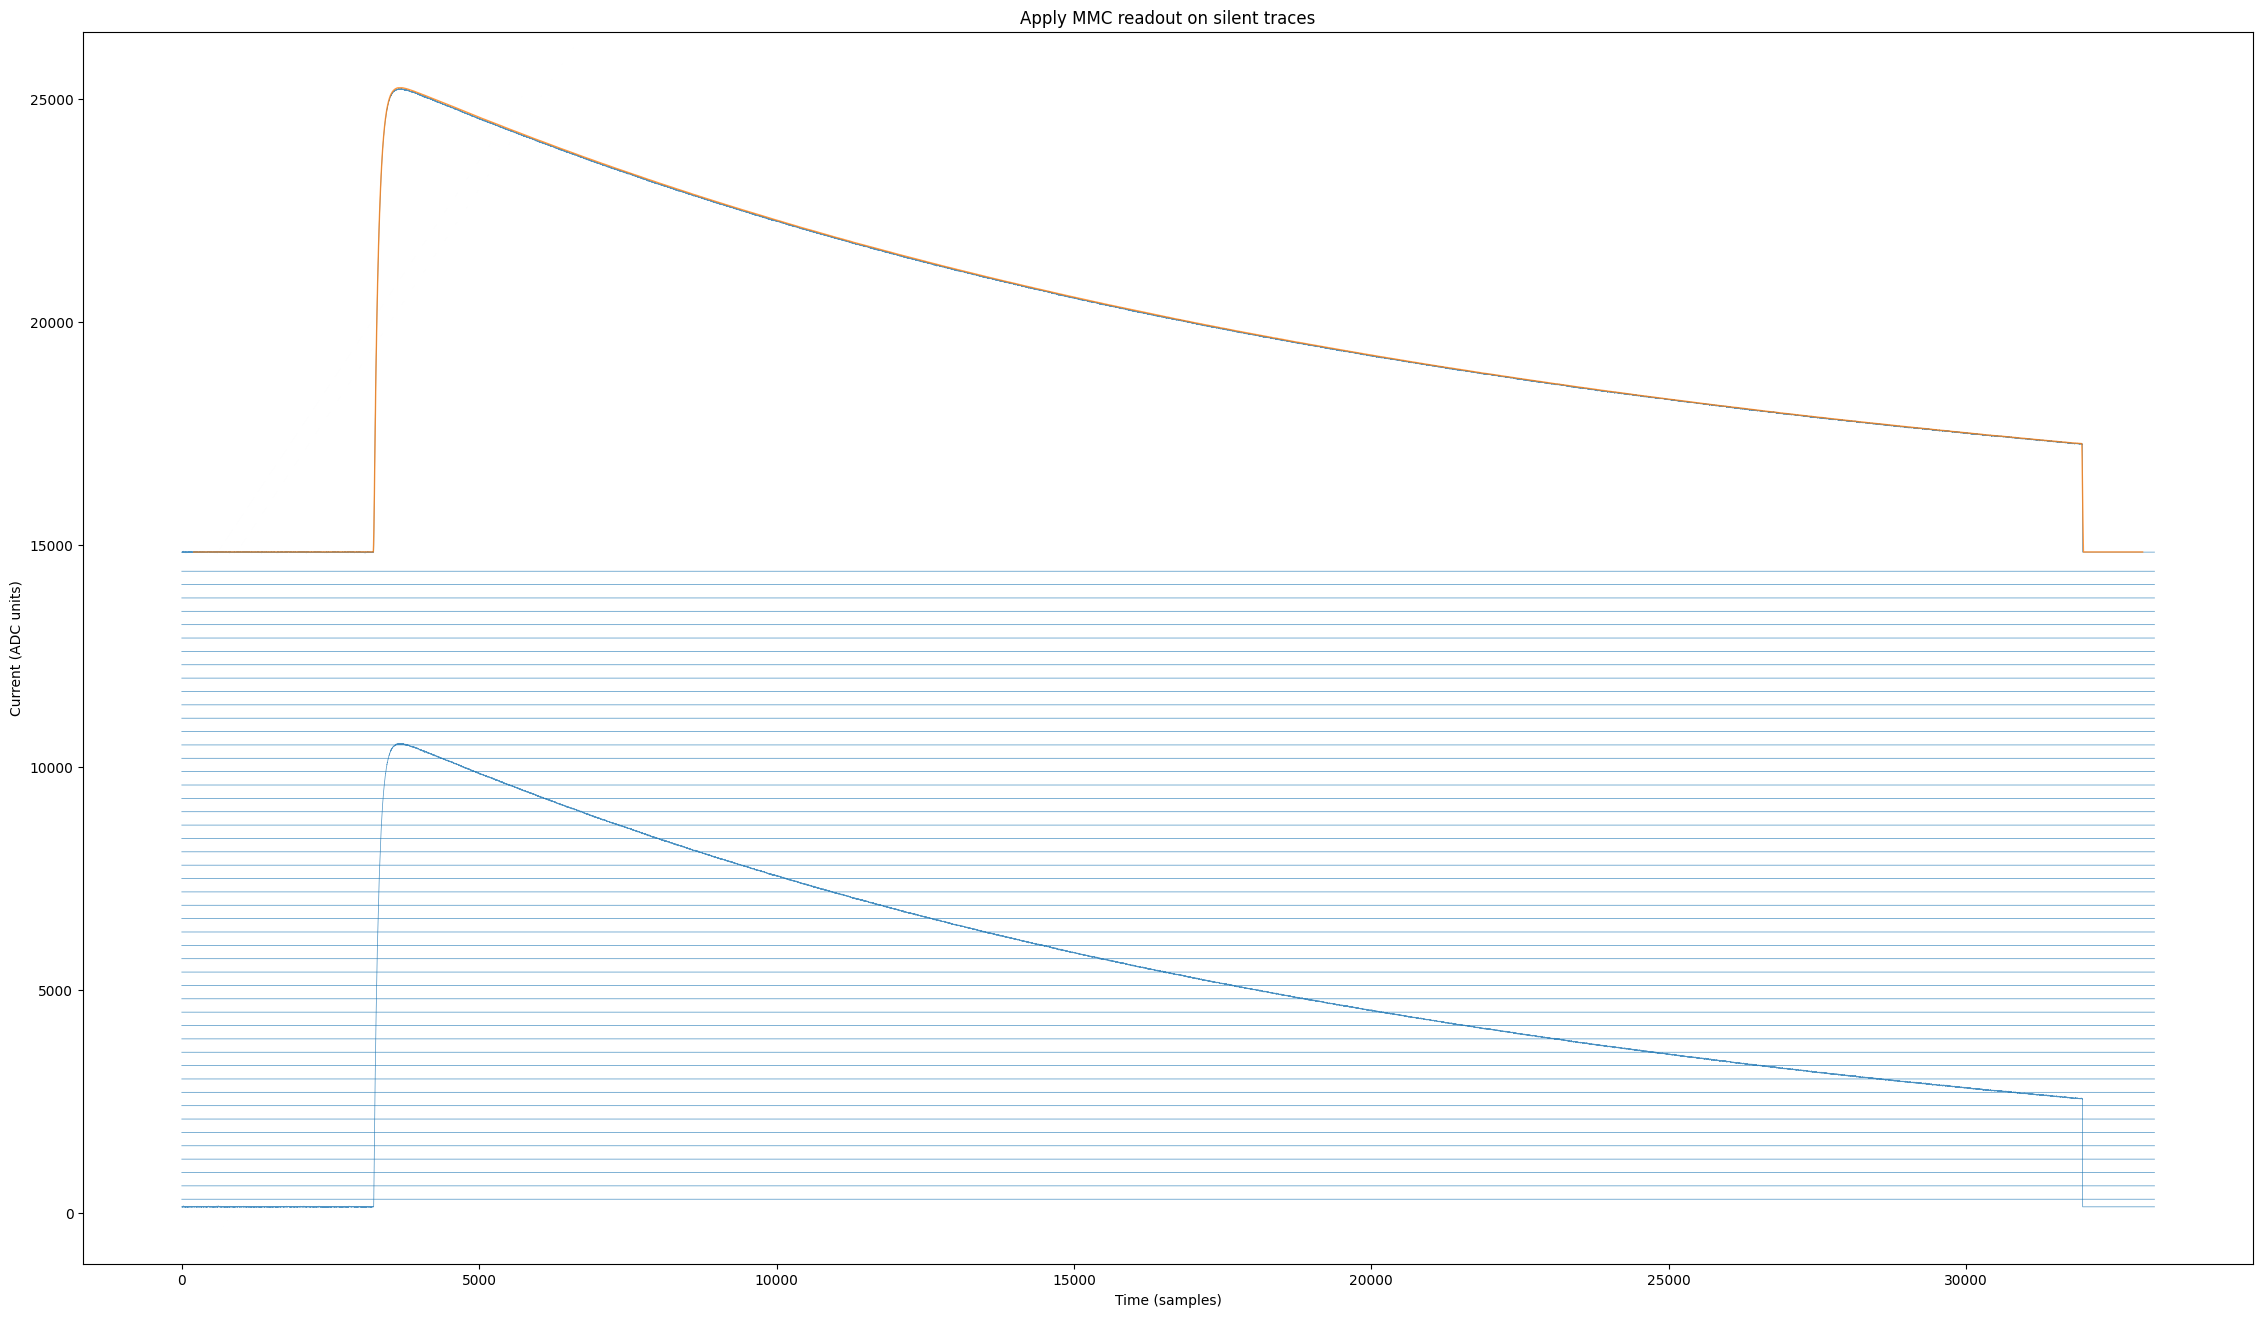

In [12]:
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

template_path = './plugins/event_rqs/2level2_template.npy'

template = np.load(template_path, allow_pickle=True)
template = template[0]
i_evt = 8
event = fit_results[i_evt]



plt.figure(figsize=(28,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][0].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel


fit = event['vacuum_channel_uv_amplitude'][-1] * np.roll(template, event['vacuum_channel_uv_offset'][-1])+ hx.DEFAULT_MMC_BASELINE_LIFT + 300*49
x = np.arange(len(template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]  # currently, the FitResults plugin does not fit the entire event. It skips -hx.DEFAULT_ALLOWED_FIT_SHIFTS[0] samples.
plt.plot(x, fit, lw=1, alpha=0.8, color='C1')

plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Apply MMC readout on silent traces')
plt.show()

In [8]:
for i in range(9):
    event = fit_results[i]
    print(event['vacuum_channel_uv_amplitude'][-1])
    print(event['submerged_channel_uv_amplitude'][0])
    print()
    


-51.07667833563755
10397.219242441686

-18.51638073421782
10415.137528660178

-21.92748768912861
10487.03575516869

-33.16242784392671
10396.8175724518

11438.879860902904
11394.065019921305

-12.362941075552953
10409.512863788155

10409.037827748718
10394.442752273282

10438.20742466327
10401.517298529401

10426.172854358563
10405.477208559414



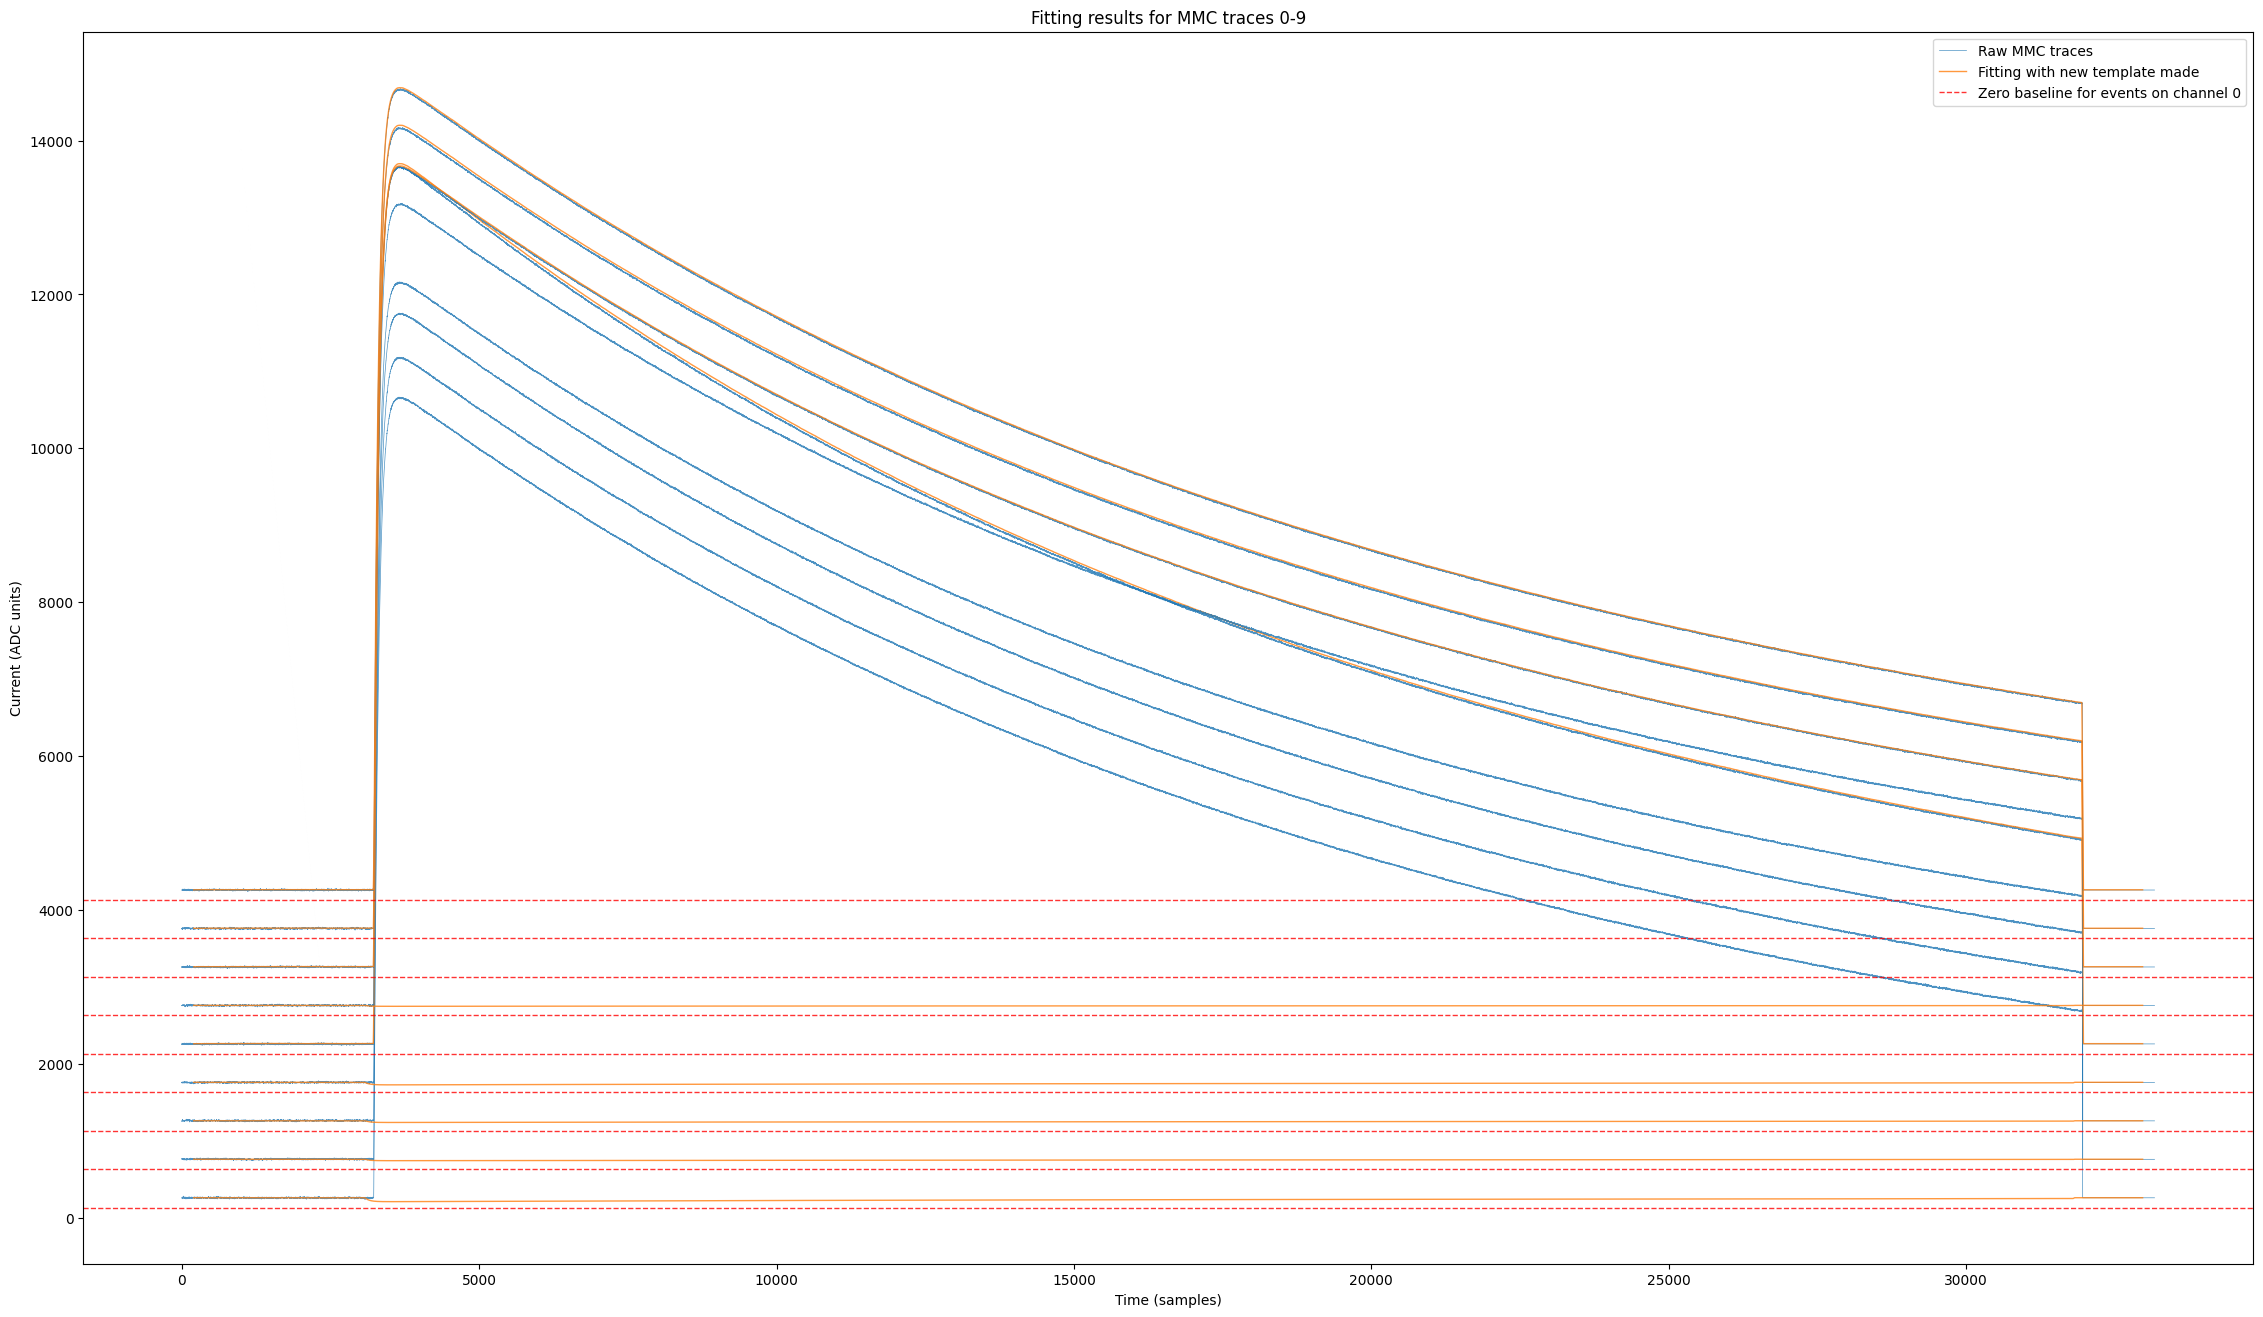

In [18]:
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

# Load template
template_path = './plugins/event_rqs/2level2_template.npy'
template = np.load(template_path, allow_pickle=True)[0]

# Number of events to plot
num_events = len(fit_results)

plt.figure(figsize=(28, 16))

# Loop over events
for i_evt in range(num_events):
    event = fit_results[i_evt]
    
    # Extract channel 0 data
    channel0_data = events['channel_data'][i_evt][49]
    
    # Apply artificial baseline to spread events out
    baseline_shift = i_evt * 500 + 130  # MMC traces baseline set to 130
    
    # Plot raw data for channel 0
    plt.plot(channel0_data + baseline_shift, lw=0.5, alpha=0.8, color='C0', label='Raw MMC traces' if i_evt == 0 else None)
    
    # Compute fit for channel 0
    fit = event['vacuum_channel_uv_amplitude'][-1] * np.roll(template, event['vacuum_channel_uv_offset'][-1]) + 130 + baseline_shift
    
    # Compute x-axis range considering skipped samples
    x = np.arange(len(template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]
    
    # Plot fit curve
    plt.plot(x, fit, lw=1, alpha=0.8, color='C1', label='Fitting with new template made' if i_evt == 0 else None)
    
    # Mark the 0 baseline with a red dashed line
    plt.axhline(y=baseline_shift, color='red', linestyle='--', linewidth=1, alpha=0.8, label='Zero baseline for events on channel 0' if i_evt == 0 else None)

plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title('Fitting results for MMC traces 0-9')
plt.legend()
plt.show()

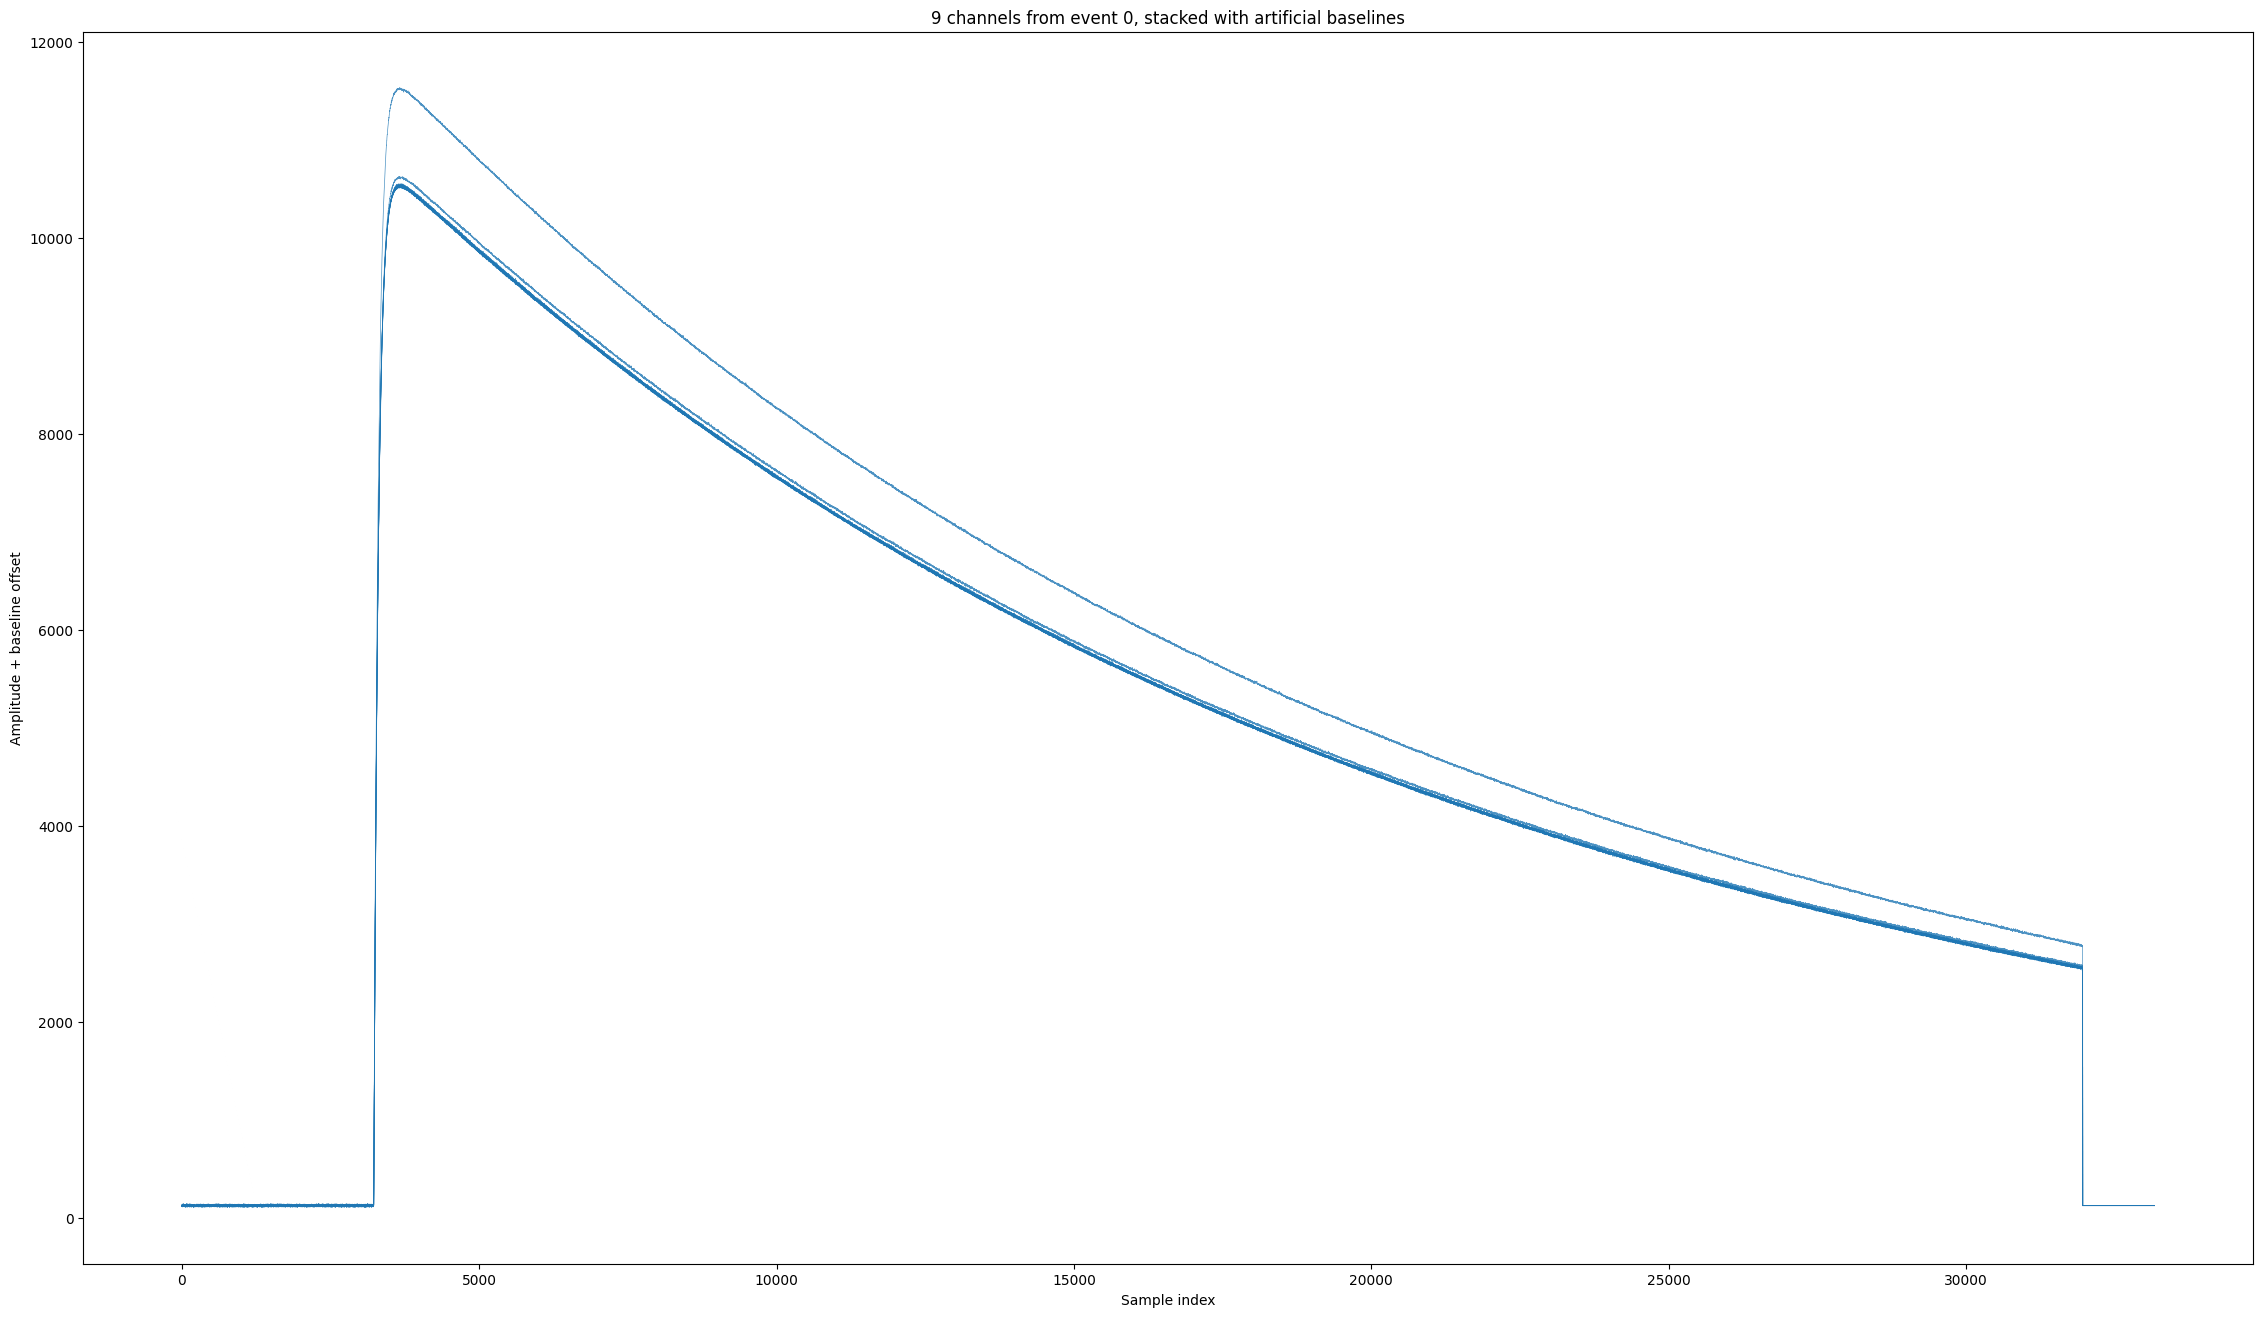

In [9]:

event0_data = raw_data[:, 0, :]

# 2. Create artificial baselines for each channel
n_channels = event0_data.shape[0]  # 9
baseline_step = 300                # vertical offset between channels
baselines = np.arange(n_channels) * baseline_step  # shape (9,)

# 3. Add these baselines to each channel
#    event0_data shape is (9, 33168)
#    baselines   shape is (9,)
#    We use baselines[:, None] to make it (9, 1),
#    so it broadcasts across the 33168 samples.
stacked_data = event0_data  # shape still (9, 33168)

# 4. Plot
plt.figure(figsize=(28, 16))

# We transpose to shape (33168, 9) so each column is one channel trace.
# This way, plt.plot(...) will draw 9 separate lines.
plt.plot(stacked_data.T, lw=0.5, alpha=0.8, color='C0')

plt.xlabel("Sample index")
plt.ylabel("Amplitude + baseline offset")
plt.title("9 channels from event 0, stacked with artificial baselines")
plt.show()

In [9]:
qp_triggers

array([],
      dtype=[(('Start time since unix epoch [ns]', 'time'), '<i8'), (('Length of the interval in samples', 'length'), '<i8'), (('Width of one sample [ns]', 'dt'), '<i2'), (('Channel number', 'channel'), '<i2'), (('Channel type', 'channel_type'), '<i2'), (('Id of the block of records in the run', 'block_id'), '<i4'), (('Sample index in the record where the filtered record crossed the threshold', 'start_loc'), '<i4'), (('Sample index in the record where the filtered record reached the maximum', 'loc'), '<i4'), (('Max amplitude of the filtered record withing the trigger', 'amplitude'), '<f4'), (('Whether or not the deactivation threshold was crossed', 'deactivation_crossed'), 'u1')])

In [10]:
event['submerged_channel_uv_amplitude']

array([10405.47720856,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ])